In [14]:
#code I used to rearrange the file from dark sky meter to be the right format
#might be useful again if I re-download the data

import csv

with open('dsm_database.csv', 'r') as infile, open('reordered_dsm.csv', 'a') as outfile:
    # output dict needs a list for new column ordering
    fieldnames = ['_date', '_moon', '_deviceangle', '_lat', '_lng', '_typedesc', '_device', '_nelm','_type','_clouds','_user_tag','_sqm']
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    # reorder the header first
    writer.writeheader()
    for row in csv.DictReader(infile):
        # writes the reordered rows to the new file
        writer.writerow(row)

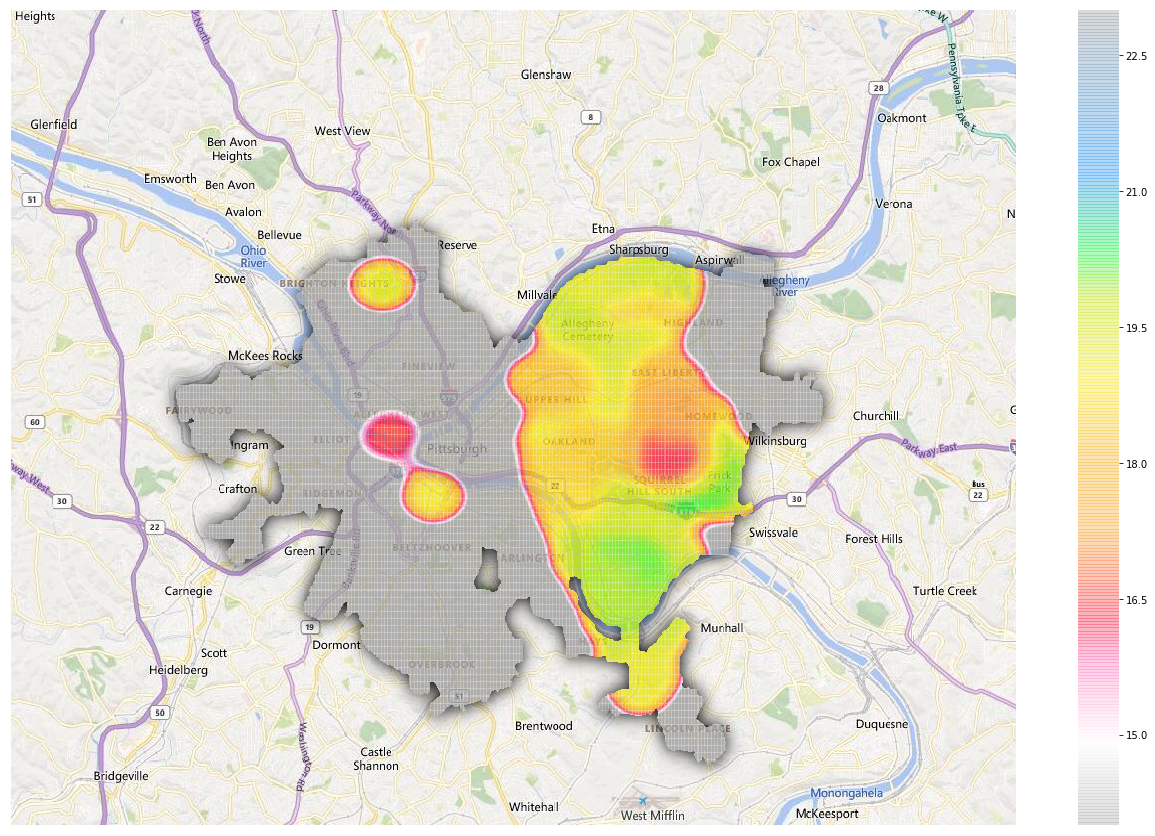

In [34]:
#code used for generating heat maps

import csv
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

#these are aesthetic and can be adjusted as you see fit
#higher dimensions can take a while so use 100 and 5 for testing
DIM = 700
RADIUS = 30
SIGMA = RADIUS/4
#boundaries of the image
LAT_MIN = 40.35
LAT_MAX = 40.55
LONG_MIN = -80.15
LONG_MAX = -79.8

#latitude = row[3]
#longitude = row[4]
#sqm = row[11]

file_names = ['GaN2019.csv', 'GaN2018.csv', 'GaN2017.csv', 'GaN2016.csv', 'GaN2015.csv', 'GaN2014.csv',\
             'GaN2013.csv', 'GaN2012.csv', 'GaN2011.csv', 'GaN2010.csv', 'reordered_dsm.csv']

data = np.zeros((DIM, DIM))

averages = [[0] * DIM for i in range(DIM)]

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

#without countours
hc = ['#a0a0a0', '#ffffff', '#FF69B4', '#f7163f', '#f7a325', '#f7b016', '#f7e816', '#bde204', '#16f734', '#168ef7', '#939596'] #COLORS
th = [0, 0.1, 0.2, 0.25, 0.36, 0.45, 0.55, 0.65, 0.7, 0.8, 1]

#with contours
#hc = ['#a0a0a0', '#ffffff', '#ffffff','#000000', '#FF69B4', '#f7163f', '#f7163f', '#000000', \
#      '#f7a325', '#f7b016', '#f7b016', '#000000', '#f7e816', '#f7e816', '#000000', '#bde204', '#16f734', '#16f734', '#000000', '#168ef7', '#939596'] #COLORS
#th = [0, 0.1, 0.193, 0.195, 0.2, 0.25, 0.353, 0.354, 0.36, 0.45, 0.543, 0.545, 0.55, 0.643, 0.645, 0.65, 0.7, 0.793, 0.796, 0.8, 1] #thresholds

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

def add_data_pt(avg_list, lat, long, sqm):
    if isinstance(avg_list[lat][long], list):
        cur_val = avg_list[lat][long][0]
        num_data_pts = avg_list[lat][long][1]
        avg_list[lat][long][0] = sqm #((num_data_pts*cur_val)+sqm)/(num_data_pts+1) #average
        avg_list[lat][long][1] += 1
    else:
        avg_list[lat][long] = [sqm, 1]
        
def add_radius(avg_list, lat, long, sqm, radius):
    for x in range(DIM):
        for y in range(DIM):
            distance = math.sqrt((x-long)**2 + (y-lat)**2)
            if distance <= radius:
                add_data_pt(avg_list, x, y, sqm)
        
for file_name in file_names:
    with open('datasets/' + file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            try: #some of the rows are empty/have missing values which causes errors, we can skip those lines
                if float(row[3]) < LAT_MAX and float(row[3]) > LAT_MIN and float(row[4]) < LONG_MAX and float(row[4]) > LONG_MIN:
                    #remember that since longitude is negative, the heatmap is actually reversed.
                    #^ this problem is solved by subtracting long from DIM.
                    lat = DIM*(LAT_MAX-float(row[3]))/(LAT_MAX-LAT_MIN)
                    long = DIM - DIM*(LONG_MAX-float(row[4]))/(LONG_MAX-LONG_MIN)
                    #print(lat, long)
                    add_radius(averages, long, lat, float(row[11]), RADIUS)
            except:
                pass

for x in range(DIM):
    for y in range(DIM):
        try: 
            data[x][y] = averages[x][y][0]
        except:
            data[x][y] = 0

from scipy.ndimage.filters import gaussian_filter
data = gaussian_filter(data, sigma=SIGMA)

with open("fulldataset.csv", 'w+') as dataset:
    dataWriter = csv.writer(dataset,delimiter=',')
    dataWriter.writerows(data)

plt.subplots(figsize=(22.5,15))
heat_map = sb.heatmap(data, cmap=cm, vmin=14, vmax=23, alpha=0.35, xticklabels=False, yticklabels=False)
#plt.show()

# get the map image as an array so we can plot it 
import matplotlib.image as mpimg 
map_img_bottom = mpimg.imread('img/bigger-map-all.png') 
map_img_top = mpimg.imread('img/bigger-map-transparent.png')

hmax = heat_map

hmax.imshow(map_img_bottom,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 0) #put the map under the heatmap
hmax.imshow(map_img_top,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the transparent map over the heatmap


plt.savefig("heatmap2.png")
plt.show()